In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Add project root to Python path
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)


pd.set_option("display.max_columns", None)


In [13]:
from src.anomaly_detector import detect_anomalies


In [14]:
daily_kpis = pd.read_csv("../data/kpi/daily_kpis.csv")
daily_kpis["date"] = pd.to_datetime(daily_kpis["date"])

daily_kpis.head()


,date,revenue,orders,customers,quantity,aov
0,2010-12-01,46376.49,121,95,24215,383.276777
1,2010-12-02,47316.53,137,99,31142,345.376131
2,2010-12-03,23921.71,57,50,11839,419.679123
3,2010-12-05,31771.60,87,75,16449,365.190805
4,2010-12-06,31215.64,94,82,16291,332.081277


In [15]:
daily_kpis = daily_kpis.sort_values("date")
daily_kpis.describe()


,date,revenue,orders,customers,quantity,aov
count,305,305.000000,305.000000,305.000000,305.000000,305.000000
mean,2011-06-10 20:03:56.065573888,29217.730833,60.760656,54.960656,16943.645902,484.496444
min,2010-12-01 00:00:00,3457.110000,11.000000,11.000000,2048.000000,228.742800
25%,2011-03-10 00:00:00,18021.481000,44.000000,41.000000,10831.000000,362.003704
50%,2011-06-14 00:00:00,25489.660000,58.000000,52.000000,15122.000000,417.752239
75%,2011-09-12 00:00:00,36751.250000,72.000000,65.000000,20863.000000,521.094746
max,2011-12-09 00:00:00,184349.280000,137.000000,125.000000,90582.000000,4496.323902
std,NaN,17854.997860,24.798764,21.447574,10129.269607,313.564544


In [16]:
WINDOW = 7

daily_kpis["revenue_mean"] = (
    daily_kpis["revenue"]
    .rolling(WINDOW, min_periods=WINDOW)
    .mean()
)

daily_kpis["revenue_std"] = (
    daily_kpis["revenue"]
    .rolling(WINDOW, min_periods=WINDOW)
    .std()
)

daily_kpis["revenue_zscore"] = (
    (daily_kpis["revenue"] - daily_kpis["revenue_mean"])
    / daily_kpis["revenue_std"]
)


In [17]:
Z_THRESHOLD = 2

daily_kpis["revenue_anomaly"] = (
    daily_kpis["revenue_zscore"].abs() > Z_THRESHOLD
)


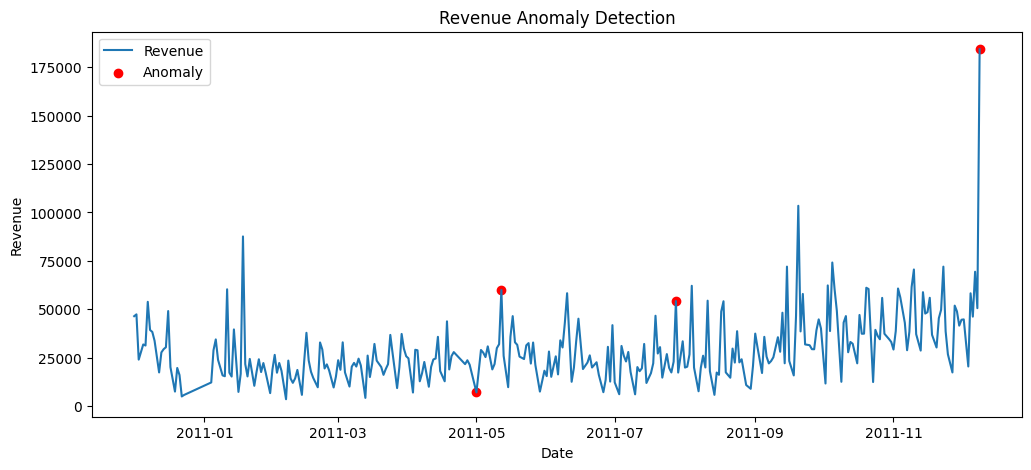

In [18]:
plt.figure(figsize=(12, 5))
plt.plot(daily_kpis["date"], daily_kpis["revenue"], label="Revenue")

anomalies = daily_kpis[daily_kpis["revenue_anomaly"]]
plt.scatter(
    anomalies["date"],
    anomalies["revenue"],
    color="red",
    label="Anomaly"
)

plt.title("Revenue Anomaly Detection")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.show()


In [19]:
incidents = daily_kpis[
    daily_kpis["revenue_anomaly"]
][
    ["date", "revenue", "revenue_zscore"]
].copy()

incidents["incident_type"] = np.where(
    incidents["revenue_zscore"] < 0,
    "NEGATIVE",
    "POSITIVE"
)

incidents


,date,revenue,revenue_zscore,incident_type
116,2011-05-01,6973.66,-2.040549,NEGATIVE
125,2011-05-12,59901.56,2.116806,POSITIVE
190,2011-07-28,54198.37,2.072513,POSITIVE
304,2011-12-09,184349.28,2.177567,POSITIVE


In [20]:
incidents.to_csv(
    "../data/kpi/revenue_incidents.csv",
    index=False
)


In [21]:
from src.anomaly_detector import detect_anomalies

test_df = detect_anomalies(
    daily_kpis,
    value_col="revenue"
)

test_df[test_df["revenue_anomaly"]].head()


,date,revenue,orders,customers,quantity,aov,revenue_mean,revenue_std,revenue_zscore,revenue_anomaly
116,2011-05-01,6973.66,18,18,3819,387.425556,20835.860000,6793.368044,-2.040549,True
125,2011-05-12,59901.56,84,68,37145,713.113810,31167.305714,13574.343598,2.116806,True
190,2011-07-28,54198.37,78,68,29699,694.850897,26551.343000,13339.857931,2.072513,True
304,2011-12-09,184349.28,41,35,90582,4496.323902,67665.542857,53584.447266,2.177567,True
